---
title: "HDA Extract Location Values - Tutorial"
subtitle: "This notebook provides a hands-on introduction to working with data from the Destination Earth Climate Digital Twin (DT)."
author: "Author: Eumetsat"
tags: [HDA, ECMWF, Digital Twin]
thumbnail: ../../img/ECMWF.png
license: MIT
copyright: "© 2025 EUMETSAT"
---
<div style="margin: 6px 0;">
  <a href="https://jupyter.central.data.destination-earth.eu/user-redirect/lab/tree/DestinE-DataLake-Lab/HDA/DestinE%20Digital%20Twins/ClimateDT-ParameterPlotter.ipynb" target="_blank" style="text-decoration: none;">
    <span class="launch">🚀 Launch in JupyterHub</span>
  </a>
</div>

# Is it going to rain in the next 3 weekends?

This notebook provides a hands-on introduction to working with data from the **Destination Earth Climate Digital Twin (DT).**
The goal is to give you a quick taste of how to access, explore, and handle DT data. It’s not meant to be a scientific study, but rather an accessible walkthrough that highlights some of the possibilities the data offers.


> "A simple question with local impact: will it rain here soon?"

In this exercise we will:

1. Select the right variable/scenario from the Climate DT in order to have precipitation forecasts. 
2. Order the Climate DT data
3. Extract values for your place location.  
4. Aggregate rainfall totals over each weekend and report the answer in text and in a plot

## Setup
Let's import useful packages

In [1]:
import destinelab as deauth
import json
import importlib
import importlib.metadata as metadata
import requests
from requests.adapters import HTTPAdapter
import os
from getpass import getpass
from tqdm import tqdm
import time
from urllib.parse import unquote
from time import sleep
from IPython.display import JSON
import sys
from packaging import version
from IPython.display import display, HTML
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

## 1 - Select the right variable/scenario from the Climate DT in order to have precipitation forecasts.

Use the [Simulation Selection](ClimateDT-ParameterPlotter.ipynb#Scenario-Simulation-Selection) to select the desired scenario simulation for Climate DT data and [Parameter Selection](ClimateDT-ParameterPlotter.ipynb#Parameter-Selection) to select the total precipitation  variable for the selected scenario.
We then need to select our time range of interest starting from the next Friday.

The selection will give you the json payload to place the order via HDA.


In [2]:
order_body={
'ecmwf:resolution': 'high',
 'ecmwf:model': 'IFS-NEMO',
 'ecmwf:type': 'fc',
 'ecmwf:dataset': 'climate-dt',
 'ecmwf:param': '228',
 'ecmwf:levtype': 'sfc',
 'ecmwf:expver': '0001',
 'ecmwf:date': '20251002/to/20251020',
 'ecmwf:realization': '1',
 'ecmwf:activity': 'ScenarioMIP',
 'ecmwf:class': 'd1',
 'ecmwf:stream': 'clte',
 'ecmwf:time': '2300',
 'ecmwf:experiment': 'SSP3-7.0',
 'ecmwf:generation': '1'}



To place the order we need to authenticate using our DESP account

In [4]:
DESP_USERNAME = input("Please input your DESP username: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


Check if we can access DT

In [5]:
installed_version = importlib.metadata.version("destinelab")
version_number = installed_version.split('.')[1]

cond1 = int(version_number) >= 8 
cond2 = float(installed_version) < 1
cond3 = float(installed_version) >= 1

if (cond1 and cond2) or cond3:
    auth.is_DTaccess_allowed(access_token)

DT Output access allowed


## 2 - Order the Climate DT data

In [6]:
HDA_STAC_ENDPOINT="https://hda.data.destination-earth.eu/stac/v2"
COLLECTION_ID="EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION"

In [7]:
response = requests.post(f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/order", json=order_body, headers=auth_headers)

if response.status_code != 200:
    print(response.content)
response.raise_for_status()

ordered_item = response.json()

product_id = ordered_item["id"]
storage_tier = ordered_item["properties"].get("storage:tier", "online")
order_status = ordered_item["properties"].get("order:status", "unknown")
federation_backend = ordered_item["properties"].get("federation:backends", [None])[0]

print(f"Product ordered: {product_id}")
print(f"Provider: {federation_backend}")
print(f"Storage tier: {storage_tier} (product must have storage tier \"online\" to be downloadable)")
print(f"Order status: {order_status}")    

Product ordered: 4aaac2fd-8036-497e-8ba2-dbabf48cedd4
Provider: dedt_lumi
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: shipping


In [8]:
#timeout and step for polling (sec)
TIMEOUT = 300
STEP = 1
ONLINE_STATUS = "online"

self_url = f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/items/{product_id}"
item = {}

for i in range(0, TIMEOUT, STEP):
    print(f"Polling {i + 1}/{TIMEOUT // STEP}")

    response = requests.get(self_url, headers=auth_headers)
    if response.status_code != 200:
        print(response.content)
    response.raise_for_status()
    item = response.json()

    storage_tier = item["properties"].get("storage:tier", ONLINE_STATUS)

    if storage_tier == ONLINE_STATUS:
        download_url = item["assets"]["downloadLink"]["href"]
        print("Product is ready to be downloaded.")
        print(f"Asset URL: {download_url}")
        break

    start = time.perf_counter()
    while time.perf_counter() - start < 1:
        pass  # do nothing for ~1 second
else:
    order_status = item["properties"].get("order:status", "unknown")
    print(f"We could not download the product after {TIMEOUT // STEP} tries. Current order status is {order_status}")

Polling 1/300
Polling 2/300
Polling 3/300
Polling 4/300
Polling 5/300
Product is ready to be downloaded.
Asset URL: https://hda-download.lumi.data.destination-earth.eu/data/dedt_lumi/EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION/4aaac2fd-8036-497e-8ba2-dbabf48cedd4/downloadLink


In [9]:
response = requests.get(download_url, stream=True, headers=auth_headers)
response.raise_for_status()

content_disposition = response.headers.get('Content-Disposition')
total_size = int(response.headers.get("content-length", 0))
if content_disposition:
    filename = content_disposition.split('filename=')[1].strip('"')
    filename = unquote(filename)
else:
    filename = os.path.basename(self_url)

# Open a local file in binary write mode and write the content
print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

downloading 4aaac2fd-8036-497e-8ba2-dbabf48cedd4.grib


253MB [00:06, 36.5MB/s] 


### 3 - Extract values for your place location

In [10]:
#Riga
your_place_lon= 24.11
your_place_lat= 56.95

In [11]:
#London
your_place_lon= -0.128
your_place_lat= 51.508

In [ ]:
#Darmstad
your_place_lon= 8.65
your_place_lat=49.88

In [ ]:
#Milan
your_place_lon= 9.25
your_place_lat=45.46

In [11]:
from earthkit.data import from_source
import earthkit.data as ekd
from earthkit.geo import  nearest_point_kdtree

ds = from_source("file",filename)
ds.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,tp,surface,0,20251002,2300,0-1,fc,None,healpix
1,ecmf,tp,surface,0,20251003,2300,0-1,fc,None,healpix
2,ecmf,tp,surface,0,20251004,2300,0-1,fc,None,healpix
3,ecmf,tp,surface,0,20251005,2300,0-1,fc,None,healpix
4,ecmf,tp,surface,0,20251006,2300,0-1,fc,None,healpix
5,ecmf,tp,surface,0,20251007,2300,0-1,fc,None,healpix
6,ecmf,tp,surface,0,20251008,2300,0-1,fc,None,healpix
7,ecmf,tp,surface,0,20251009,2300,0-1,fc,None,healpix
8,ecmf,tp,surface,0,20251010,2300,0-1,fc,None,healpix
9,ecmf,tp,surface,0,20251011,2300,0-1,fc,None,healpix


In [12]:
import earthkit.data as ekd
from earthkit.geo import nearest_point_haversine

latlon = ds.to_latlon()
lat = latlon["lat"]
lon = latlon["lon"]

p_ref = (your_place_lat, your_place_lon)
idx, dist = nearest_point_haversine(p_ref, (lat, lon))
idx, dist

(array([750865]), array([3445.65461327]))

In [13]:
ds_xr=ds.to_xarray()
subset = ds_xr.isel(values=idx)

In [ ]:
subset

In [14]:
weekends = pd.date_range("2025-10-02", periods=3, freq="7D")

weekends

DatetimeIndex(['2025-10-02', '2025-10-09', '2025-10-16'], dtype='datetime64[ns]', freq='7D')

In [15]:
results = {}

for start in weekends:
    # Weekend = Sat (start) + Sun (start+1)
    end = start + pd.Timedelta(days=1)
    
    weekend_data = subset.sel(forecast_reference_time=slice(start, end))
    total_precip = weekend_data['tp'].sum().item()
    
    results[str(start.date())] = "Rain" if total_precip > 0.001 else "No Rain"

display(results)

{'2025-10-02': 'No Rain', '2025-10-09': 'No Rain', '2025-10-16': 'No Rain'}

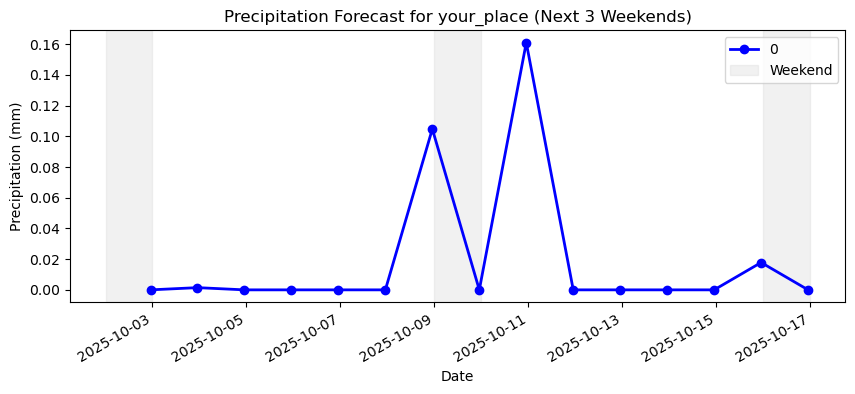

In [16]:
import matplotlib.pyplot as plt

# Extract precipitation time series for your_place
tp = subset.tp.astype("float32") * 1000
your_place_precip = tp.to_pandas()

# Plot only the period covering the 3 weekends
plot_start = weekends[0]
plot_end = weekends[-1] + pd.Timedelta(days=1)
your_place_precip = your_place_precip.loc[plot_start:plot_end]

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
your_place_precip.plot(ax=ax, lw=2, color="blue",marker="o", label="tot")

# Highlight weekends
for start in weekends:
    end = start + pd.Timedelta(days=1)
    ax.axvspan(start, end, color="lightgray", alpha=0.3, label="Weekend" if start == weekends[0] else "")

ax.set_title("Precipitation Forecast for your_place (Next 3 Weekends)")
ax.set_ylabel("Precipitation (mm)")
ax.set_xlabel("Date")
ax.legend()
plt.show()

In [ ]:
'''
#Climate data are GRIB data defined on a HEALPix nested grid.
#We can interpolate it in a regular latitude-longitude grid

from earthkit.regrid import interpolate
from earthkit.data import from_source

ds = from_source("file",filename)

# the target grid is a global 0.1x0.1 degree regular latitude-longitude grid
out_grid = {"grid": [5,5]}

# perform interpolation for each field and add results to a new fieldlist stored in memory
r = interpolate(ds, out_grid=out_grid, method="linear")

d=r.to_xarray()
'''